In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X = X_train.reshape(X_train.shape[0], -1)/255.
y = y_train

print(X.shape,y.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 784) (60000,)


In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.98,random_state=123)
print(X_train.shape,y_train.shape)

(1200, 784) (1200,)


# Ejercicio 3



1.  Consulte en que consiste el algoritmo [eigenfaces](https://direct.mit.edu/jocn/article/3/1/71/3025/Eigenfaces-for-Recognition). Compare el modelo de eigenfaces para reducción de dimensión con el algoritmo PCA. Aplique eigenfaces a Mnist sobre el conjunto `X_train` y grafique las dos primeras dimensiones con las imagenes originales sobre cada punto proyectado, y presente las cinco primeras "eigenfaces" en dibujo tipo imagen.

2. Utilizando la base de datos muestreada Mnist en `X_train` y `y_train`, realice una análisis comparativo en términos del coeficiente de silueta del agrupamiento de los datos a 2 dimensiones utilizando kmeans. Considere los métodos: PCA, kernel PCA rbf, t-SNE y UMAP. Utilice la librería [RAPIDS](https://rapids.ai/) a la hora de implementar los algoritmos, en caso de estar disponibles.


In [3]:
from sklearn.decomposition import PCA

red = PCA(n_components=0.9)
Z = red.fit_transform(X_train)

In [4]:
#graficar 2D con imágenes originales
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
#img_w y img_h representan la resolución original de los datos
def plot_mnist_2d(Z,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(10,6))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

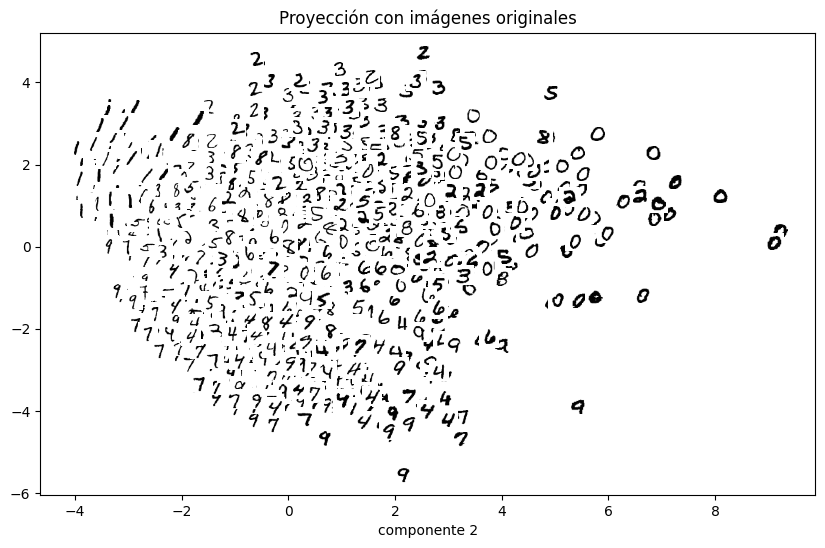

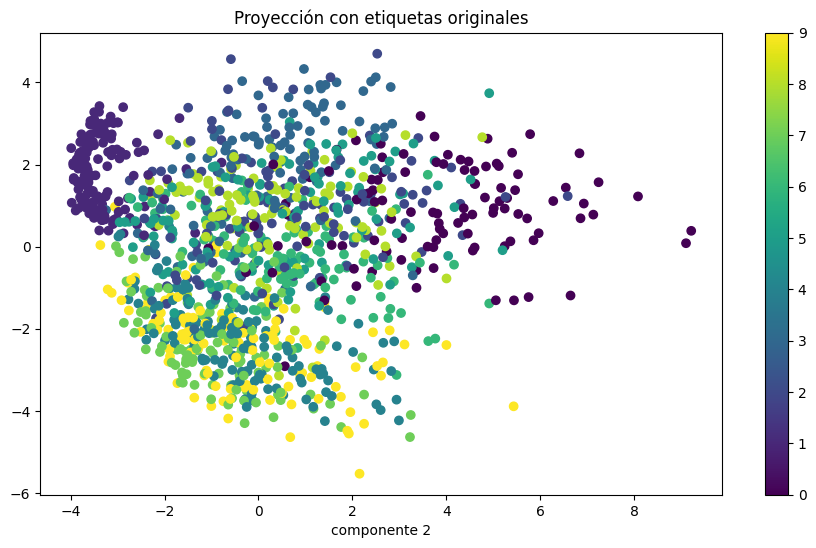

In [5]:
plot_mnist_2d(Z,X_train,img_w=28,img_h=28,zoom=0.5,cmap='binary')
plt.xlabel('componente 1')
plt.xlabel('componente 2')
plt.title('Proyección con imágenes originales')
plt.show()

plt.figure(figsize=(11,6))
plt.scatter(Z[:,0],Z[:,1],c=y_train)
plt.xlabel('componente 1')
plt.xlabel('componente 2')
plt.title('Proyección con etiquetas originales')
plt.colorbar()
plt.show()

In [6]:
#graficar componentes como "eigenfaces"
print(red.components_.shape)

(80, 784)


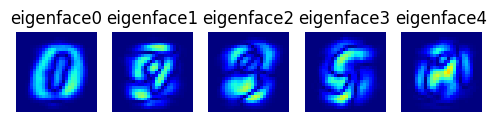

In [7]:
n_rows = 1
n_cols = 5
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
#resolución imagenes
img_w = 28
img_h = 28

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(abs(red.components_[index].reshape(img_w,img_h)),
                    vmin=abs(red.components_).min(), vmax=abs(red.components_).max(),cmap="jet", interpolation="nearest")
        plt.axis('off')
        plt.title("eigenface" + str(index), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Punto 2

In [8]:
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import pandas as pd
import cuml
import cuml.cluster
import cuml.decomposition
import cuml.manifold
import cupy as cp

In [43]:
k = 10  # MNIST tiene 10 dígitos

results = []

In [45]:
from cuml.decomposition import PCA as cuPCA
from cuml.cluster import KMeans as cuKMeans

pca_gpu = cuPCA(n_components=2)
X_pca = pca_gpu.fit_transform(cp.asarray(X_train))
X_pca_np = cp.asnumpy(X_pca)

kmeans_gpu = cuKMeans(n_clusters=k, random_state=123)
labels_pca = kmeans_gpu.fit_predict(X_pca)
sil_pca = silhouette_score(X_pca_np, cp.asnumpy(labels_pca))
results.append({'Método': 'PCA (RAPIDS)', 'Silhouette': sil_pca})

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


In [46]:
from sklearn.cluster import KMeans as SKKMeans # Kernel PCA no esta en RAPIDS, debemos usar KMean de Sklearn

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.05, random_state=123)
X_kpca = kpca.fit_transform(X_train)
kmeans_kpca = SKKMeans(n_clusters=k, random_state=123)
labels_kpca = kmeans_kpca.fit_predict(X_kpca)
sil_kpca = silhouette_score(X_kpca, labels_kpca)
results.append({'Método': 'Kernel PCA (RBF)', 'Silhouette': sil_kpca})

In [48]:
tsne = TSNE(n_components=2, random_state=123, perplexity=15, n_iter=1000)
X_tsne = tsne.fit_transform(X_train)
kmeans_tsne = SKKMeans(n_clusters=k, random_state=123)
labels_tsne = kmeans_tsne.fit_predict(X_tsne)
sil_tsne = silhouette_score(X_tsne, labels_tsne)
results.append({'Método': 't-SNE', 'Silhouette': sil_tsne})

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [49]:
reducer = umap.UMAP(n_components=2, random_state=123, target_metric='categorical')
X_umap = reducer.fit_transform(X_train)
X_umap_np = cp.asnumpy(X_umap)
kmeans_umap = cuKMeans(n_clusters=k, random_state=123)
labels_umap = kmeans_umap.fit_predict(cp.asarray(X_umap_np))
sil_umap = silhouette_score(X_umap_np, cp.asnumpy(labels_umap))
results.append({'Método': 'UMAP (RAPIDS)', 'Silhouette': sil_umap})

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


In [50]:
df_results = pd.DataFrame(results)
print(df_results)

             Método  Silhouette
0      PCA (RAPIDS)    0.355473
1      PCA (RAPIDS)    0.355473
2  Kernel PCA (RBF)    0.547756
3             t-SNE    0.447574
4             t-SNE    0.447574
5     UMAP (RAPIDS)    0.504588


PCA: Valor más bajo, lo que es esperado, ya que solo capta relaciones lineales y la estructura de MNIST es altamente no lineal.

Kernel PCA (RBF): Mejor resultado. El kernel RBF permite encontrar una estructura más útil para separar los dígitos en 2D.

t-SNE y UMAP: Ambos se desempeñan mejor que PCA lineal, mostrando que preservan mejor la estructura de los datos en 2D, aunque en este caso Kernel PCA ganó.

UMAP: Muy buen desempeño y suele ser mucho más rápido que t-SNE, especialmente en GPU.

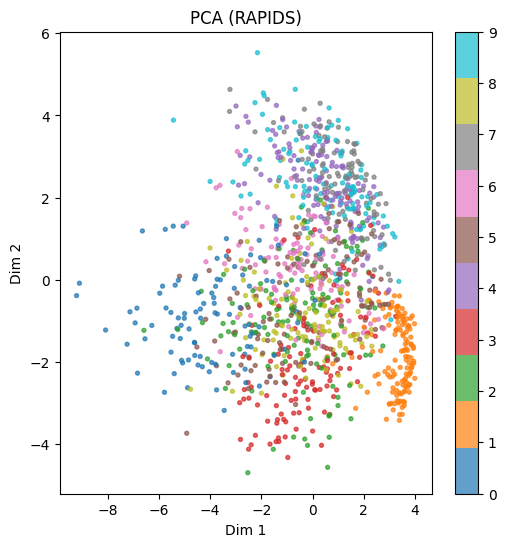

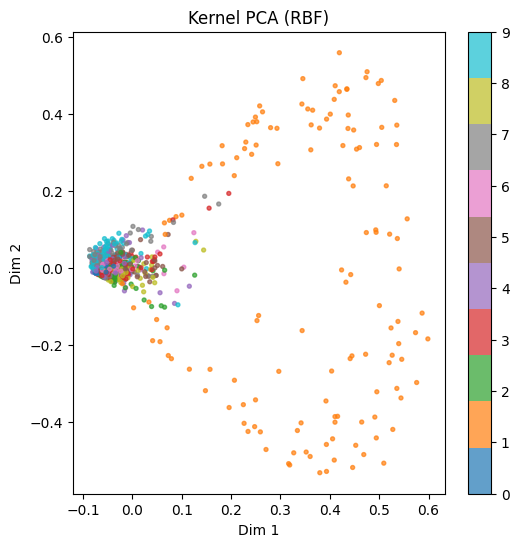

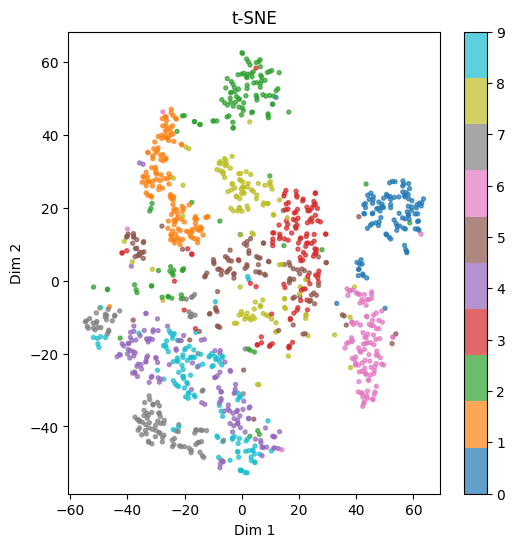

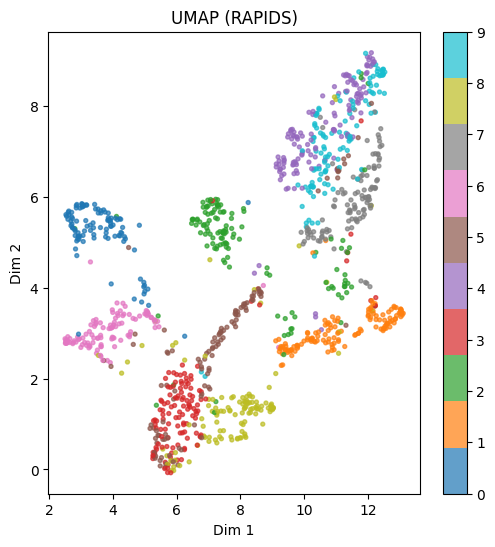

In [28]:
import matplotlib.pyplot as plt

def plot_embedding(X_embedded, y, title):
    plt.figure(figsize=(6,6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='tab10', s=8, alpha=0.7)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(scatter, ticks=range(10))
    plt.show()

# Ejemplo de uso:
plot_embedding(X_pca_np, y_train, "PCA (RAPIDS)")
plot_embedding(X_kpca, y_train, "Kernel PCA (RBF)")
plot_embedding(X_tsne, y_train, "t-SNE")
plot_embedding(X_umap_np, y_train, "UMAP (RAPIDS)")

In [35]:
from sklearn.metrics import silhouette_score

# Para cada embedding, calcula la silueta usando las clases reales
sil_pca_true = silhouette_score(X_pca_np, y_train)
sil_kpca_true = silhouette_score(X_kpca, y_train)
sil_tsne_true = silhouette_score(X_tsne, y_train)
sil_umap_true = silhouette_score(X_umap_np, y_train)

print("Silhouette (clases reales) - PCA:", sil_pca_true)
print("Silhouette (clases reales) - Kernel PCA:", sil_kpca_true)
print("Silhouette (clases reales) - t-SNE:", sil_tsne_true)
print("Silhouette (clases reales) - UMAP:", sil_umap_true)


Silhouette (clases reales) - PCA: 0.011319924685224561
Silhouette (clases reales) - Kernel PCA: -0.23827209936844157
Silhouette (clases reales) - t-SNE: 0.16588221
Silhouette (clases reales) - UMAP: 0.19834101


Para evaluar la calidad de la reducción de dimensión, comparamos el coeficiente de silueta obtenido al aplicar KMeans sobre los datos embebidos en 2D y el coeficiente de silueta calculado con las clases reales como clusters. Observamos que, aunque Kernel PCA alcanzó un alto valor de silueta según KMeans, su valor negativo de silueta usando las clases verdaderas indica que las clases originales están mezcladas en el embedding. En contraste, t-SNE y UMAP muestran valores de silueta significativamente mayores usando las clases reales, reflejando que estos métodos preservan mejor la estructura original de las clases al reducir los datos a dos dimensiones. PCA tradicional muestra bajo desempeño en ambas métricas, evidenciando sus limitaciones para capturar estructuras no lineales.

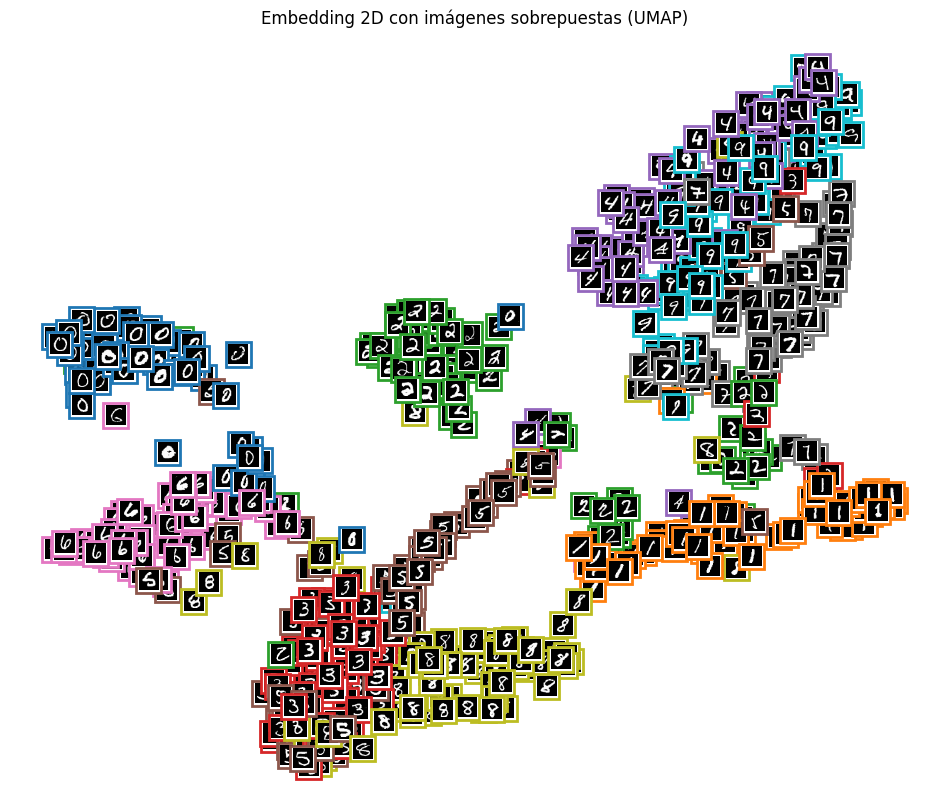

In [58]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

Z = X_umap_np
labels = y_train
images =  X_train.reshape(-1, 28, 28)
plt.figure(figsize=(12, 10))
cmap = plt.cm.tab10
plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=10, cmap=cmap, alpha=0.5)
plt.title("Embedding 2D con imágenes sobrepuestas (UMAP)")
plt.axis("off")

image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.007:  # Si está lejos de las otras imágenes
        image_positions = np.r_[image_positions, [position]]
        # Imagen debe estar en 28x28 (grayscale)
        image = images[index]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(image, cmap="gray", zoom=0.5),  # Puedes ajustar el zoom
            position,
            bboxprops={"edgecolor": cmap(labels[index]), "lw": 2},
            frameon=True,
            pad=0.2
        )
        plt.gca().add_artist(imagebox)
plt.show()


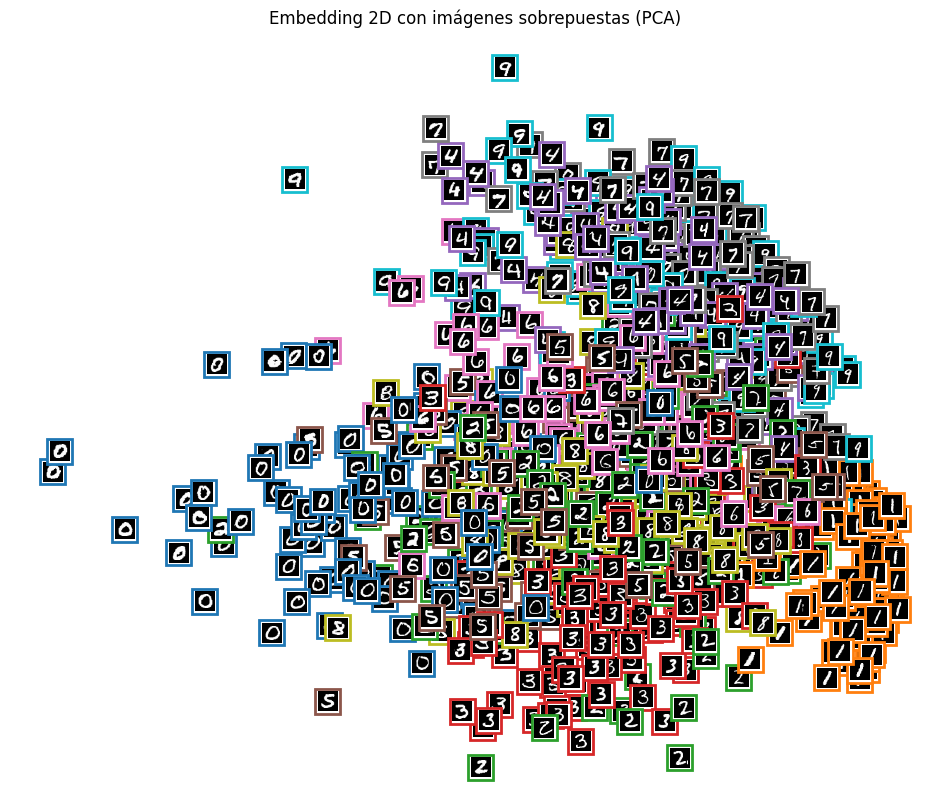

In [59]:
Z = X_pca_np
labels = y_train
images =  X_train.reshape(-1, 28, 28)
plt.figure(figsize=(12, 10))
cmap = plt.cm.tab10
plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=10, cmap=cmap, alpha=0.5)
plt.title("Embedding 2D con imágenes sobrepuestas (PCA)")
plt.axis("off")

image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.007:  # Si está lejos de las otras imágenes
        image_positions = np.r_[image_positions, [position]]
        # Imagen debe estar en 28x28 (grayscale)
        image = images[index]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(image, cmap="gray", zoom=0.5),  # Puedes ajustar el zoom
            position,
            bboxprops={"edgecolor": cmap(labels[index]), "lw": 2},
            frameon=True,
            pad=0.2
        )
        plt.gca().add_artist(imagebox)
plt.show()